# Source Location Identification for Helmholtz

**The Equation** $$ \begin{cases} \Delta u + k^2 u = -f & x\in\Omega \\ \nabla u \cdot n = g & x \in \Gamma \end{cases}$$
Take $k=1.0$, $g = 0$, and $\Omega = (0,1)^2$.  Define the source $f$ as $$ f(x) = \exp\{-10(\|x-x_0\|_2^2+\|x-x_1\|_2^2)\},$$ where $x_0$ and $x_1$ are unknown locations in $\Omega$.  We will generate synthetic data based on true parameters $x_0$ and $x_1$ randomly sampled from a Gaussian prior with $$\mu = \begin{bmatrix}0.15 \\ 0.15 \\0.15 \\0.85 \end{bmatrix}, \quad \Sigma = 0.000625*\begin{bmatrix}1 & 0.5 & 0 & 0 \\ 0.5 & 1 & 0 & 0 \\ 0 & 0 & 1 & -0.5 \\ 0 & 0 & -0.5 & 1 \end{bmatrix}.$$  Perturb the data with some Gaussian noise and invert for $x_0$ and $x_1$ using MUQ tools.

Imports

In [1]:
from __future__ import print_function, absolute_import, division

# Import FEniCS
import dolfin as dl
import math
import numpy as np

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
import pymuqModeling as mm
import pymuqSamplingAlgorithms as ms

from hippylib import nb

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

from IPython.display import Image

import pandas as pd

Define prior

In [2]:
PriorMu = np.array([0.15,0.15,0.15,0.85])
PriorCov = 0.000625*np.array([[1,0.5,0,0],[0.5,1,0,0],[0,0,1,-0.5],[0,0,-0.5,1]])
Prior = mm.Gaussian(PriorMu, PriorCov).AsDensity()

In [3]:
PriorU = mm.UniformBox([[0.,0.,0.,0.5],[1.,0.5,1.,1.]]).AsDensity()

Randomly draw true parameters from the prior.

In [4]:
from pymuqUtilities import RandomGenerator as rg
rg.SetSeed(525600)
params_true = Prior.Sample()
print("The true source locations are [x_0 x_1] = ",params_true)

The true source locations are [x_0 x_1] =  [ 0.16337829  0.15236456  0.1623722   0.82294308]


Finite element mesh and spaces

In [5]:
n = 32
d = 1
mesh = dl.UnitSquareMesh(n, n)
Vh = dl.FunctionSpace(mesh, "Lagrange", d)

Define everything for FEniCS up to the source $f$.

In [6]:
uh = dl.TrialFunction(Vh)
vh = dl.TestFunction(Vh)
g = dl.Constant(0.)
k = dl.interpolate(dl.Expression("1.0",degree=2), Vh)
a = (dl.inner(dl.grad(uh), dl.grad(vh))+dl.inner(k*uh,vh))*dl.dx

Create a child of dolfin.Expression to define the source function $f$.  
This allows for more efficient computation of $f$ when we alter $x_0$ and $x_1$.

In [7]:
class SourceExpression(dl.Expression):
    def __init__(self, srclocs, **kwargs):
        self.srclocs = srclocs

    def eval(self, values, x):
        expval = 0
        for i in range(2):
            logval = 0
            for j in range(2):
                logval += -100*(x[j]-self.srclocs[2*i+j])*(x[j]-self.srclocs[2*i+j])
            expval += np.exp(logval)
        values[0] = expval
    def value_shape(self):
        return (1,)

Define the rest of the problem for FEniCS, using the true parameters.  Solve the system.

In [8]:
f = SourceExpression(srclocs = params_true, element = Vh.ufl_element())
L = -f*vh*dl.dx+g*vh*dl.ds
A, b = dl.assemble_system(a, L)
uh = dl.Function(Vh)
dl.solve(A,uh.vector(),b)


1

Plot the true solution.

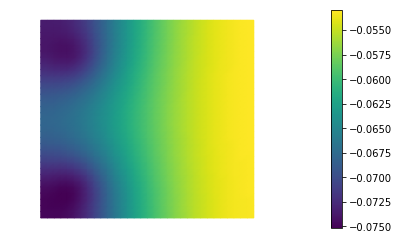

In [9]:
nb.plot(uh)

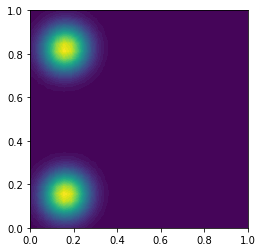

In [10]:
dl.common.plotting.plot(f,mesh=mesh)

Randomly generate observation locations.

In [11]:
n_obs = 25
np.random.seed(42069)
test_locs = np.array([np.random.uniform(low=0,high=1,size=(2,)) for i in range(n_obs)])

Perturb the solution with Gaussian random noise.

In [12]:
ud = dl.Function(Vh)
ud.assign(uh)
MAX = ud.vector().norm("linf")
noise = dl.Vector()
A.init_vector(noise,1)
noise_level = 0.005
np.random.seed(24601)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
ud.vector().axpy(1., noise)

Evaluate the perturbed state at the random observation locations.  
Plot the perturbed solution and overlay the observation locations.

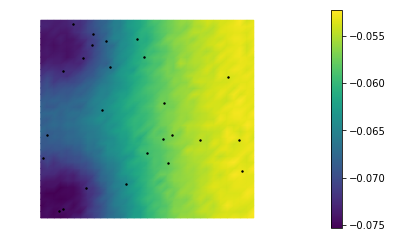

In [13]:
data = np.zeros((n_obs,))
tmp = np.zeros((1,))
for i in range(n_obs):
    ud.eval(tmp,test_locs[i,:])
    data[i] = tmp
nb.plot(ud)
ax = plt.gca()
ax.scatter(test_locs[:,0],test_locs[:,1],s=2,c='k')

Define the forward model.  EvaluateImpl takes in the source locations as a 2x2 array and outputs the solution to the Helmholtz equation at our random observation locations.

In [14]:
class ForwardHelmholtz_sourcespec(mm.PyModPiece):
    
    def __init__(self,g,k,a,uh,vh,Vh,test_locs):
        mm.PyModPiece.__init__(self, [4], 
                                     [test_locs.shape[0]]) 
        self.Vh = Vh
        self.uh = uh
        self.vh = vh
        self.g = g
        self.k = k
        self.a = a
        self.test_locs = test_locs
        
    def EvaluateImpl(self, inputs):
        m = inputs[0]
        f = SourceExpression(srclocs = m,element = Vh.ufl_element())
        L = -f*vh*dl.dx + g*vh*dl.ds
        A, b = dl.assemble_system(self.a, L)
        uh = dl.Function(self.Vh)
        dl.solve(A, uh.vector(), b)
        n_locs = test_locs.shape[0]
        vals = np.zeros((1))
        statevals = np.zeros((n_locs))
        for j in range(n_locs):
            uh.eval(vals,test_locs[j,:])
            statevals[j] = vals[0]
        self.outputs = [statevals]
FHss = ForwardHelmholtz_sourcespec(g,k,a,uh,vh,Vh,test_locs)

Define the likelihood.

In [15]:
noiseVar = 1e-3
noiseCov = noiseVar*np.eye(data.shape[0])
likelihood = mm.Gaussian(data, noiseCov).AsDensity()

Create the graph.

In [16]:
posteriorPiece = mm.DensityProduct(2)
locPiece = mm.IdentityOperator(4)

In [17]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(locPiece, "x_0,x_1")
graph.AddNode(FHss, "u(test_locs)")

graph.AddEdge("x_0,x_1", 0, "u(test_locs)", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(Prior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

graph.AddEdge("u(test_locs)", 0, "Likelihood", 0)
graph.AddEdge("x_0,x_1", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

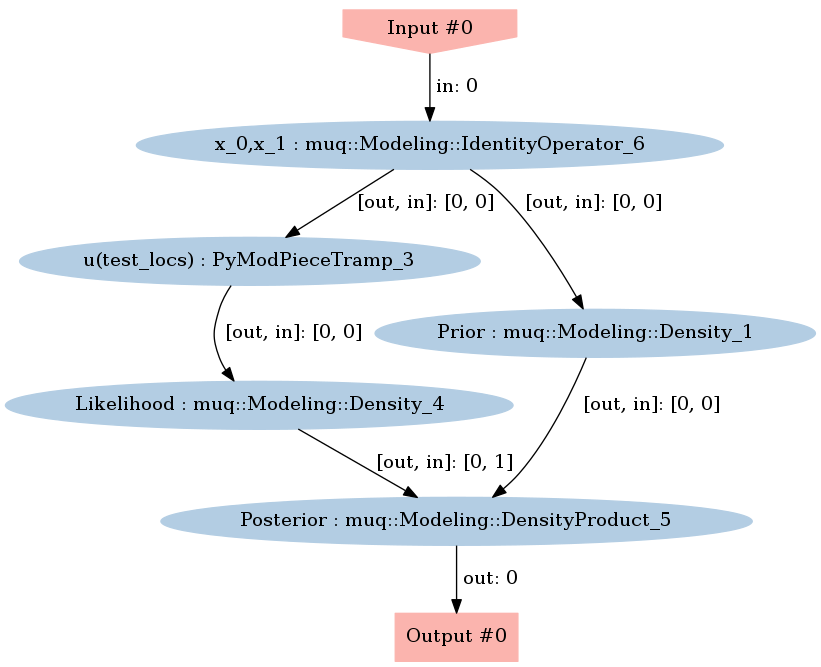

In [18]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [19]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [20]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 5e-4
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.5

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 1000
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [21]:
startPt = np.array([0.10,0.10,0.2,0.80])
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 36%
  20% Complete
    Block 0:
      Acceptance Rate = 37%
  30% Complete
    Block 0:
      Acceptance Rate = 42%
  40% Complete
    Block 0:
      Acceptance Rate = 44%
  50% Complete
    Block 0:
      Acceptance Rate = 46%
  60% Complete
    Block 0:
      Acceptance Rate = 46%
  70% Complete
    Block 0:
      Acceptance Rate = 48%
  80% Complete
    Block 0:
      Acceptance Rate = 48%
  90% Complete
    Block 0:
      Acceptance Rate = 49%
  100% Complete
    Block 0:
      Acceptance Rate = 49%
Completed in 244.242 seconds.


In [22]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

Effective Sample Size = 
 [ 213.18711885  254.49580917  267.29869411  183.80796007]

Sample mean = 
 [ 0.15220312  0.15319923  0.15030974  0.85096038]

Sample Covariance = 
 [[  5.95022650e-04   2.83098555e-04  -5.81531808e-06   2.70289380e-08]
 [  2.83098555e-04   5.92961224e-04   1.55928844e-05   2.31097073e-05]
 [ -5.81531808e-06   1.55928844e-05   5.85823210e-04  -2.94258147e-04]
 [  2.70289380e-08   2.31097073e-05  -2.94258147e-04   5.92889472e-04]]

Estimated MC error in mean = 
 [ 0.00167065  0.00152642  0.00148042  0.00179599]


In [23]:
sampMat = samps.AsMatrix()

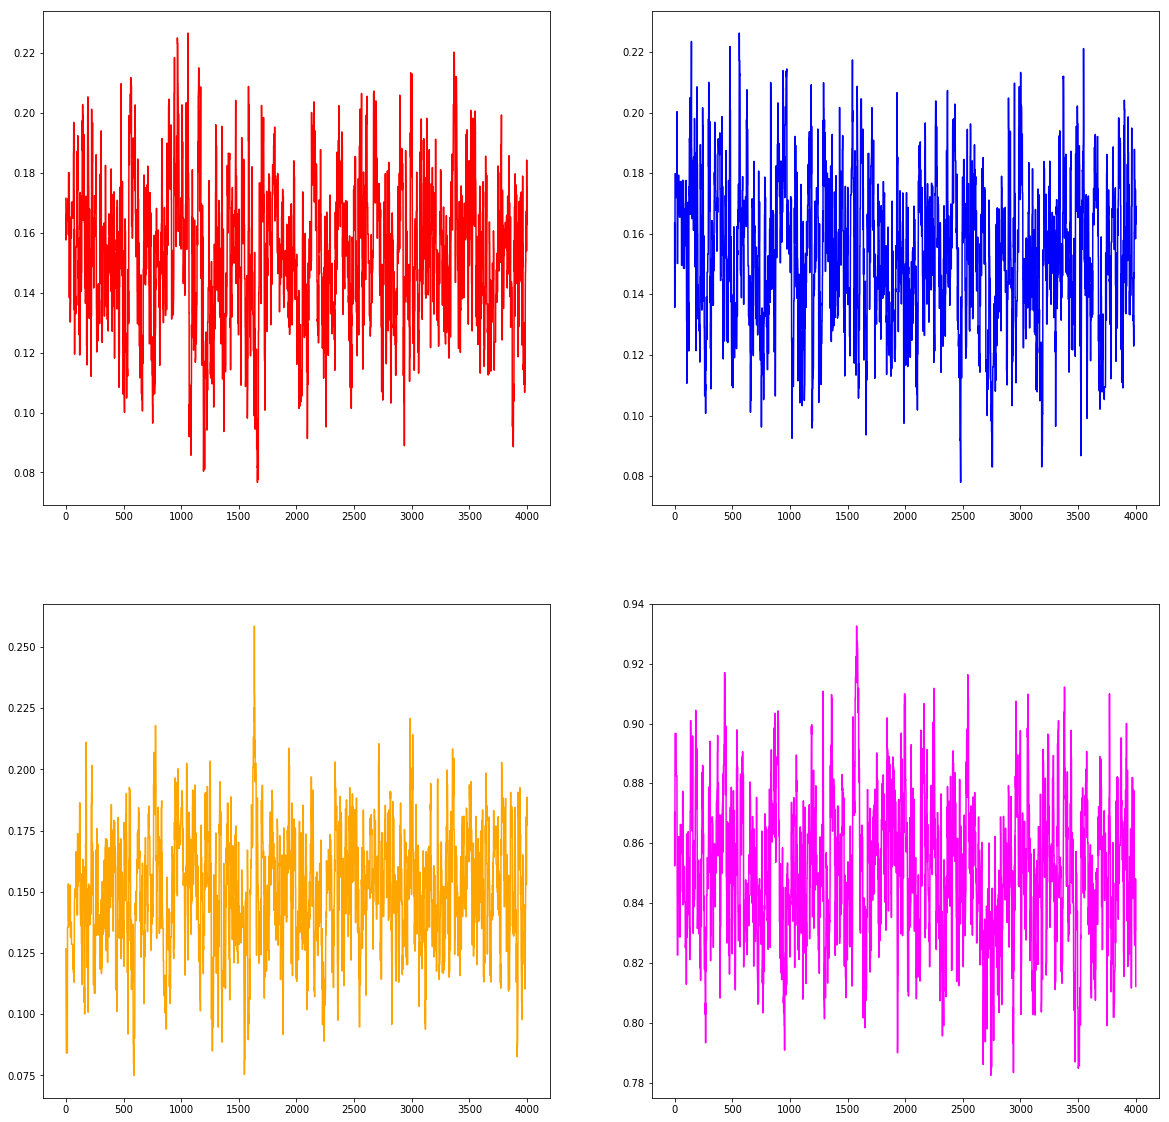

In [24]:
fig,ax = plt.subplots(2, 2, figsize=(20,20))
ax = ax.ravel()
colors = ['red', 'blue', 'orange', 'magenta']
for i in range(4):
    ax[i].plot(sampMat[i,:].T, c=colors[i])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e402c9400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2e400e26d8>]], dtype=object)

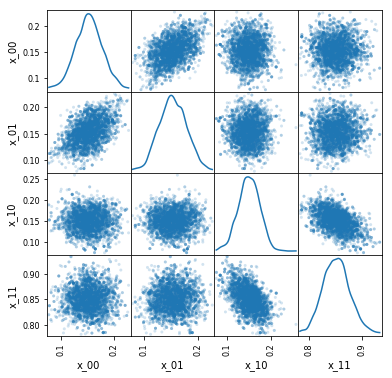

In [25]:
df = pd.DataFrame(sampMat.T, columns=['x_00','x_01','x_10','x_11'])

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

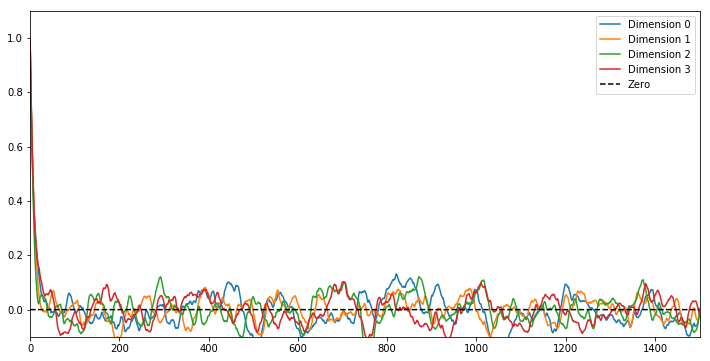

In [26]:
fig = plt.figure(figsize=(12,6))

for i in range(4):
    shiftedSamp = sampMat[i,:]-np.mean(sampMat[i,:])
    corr = np.correlate(shiftedSamp, shiftedSamp, mode='full')
    plt.plot(corr[int(corr.size/2):]/np.max(corr), label='Dimension %d'%i)
    
maxLagPlot = 1500
plt.plot(np.zeros(maxLagPlot),'--k', label='Zero')

plt.xlim([0,maxLagPlot])
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

In [27]:
np.mgrid?